In [3]:
import pandas as pd
import numpy as np
import dataset
import sqlite3
from scipy import stats as st
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from tqdm import tqdm


DB = sqlite3.connect('steamdata')
# Data was taken Feb 24, 2021


In [4]:
gamesdb = pd.read_sql_query('SELECT * FROM app', DB)


In [5]:
gamesdb.head()

,id,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
0,1,10,Counter-Strike,Valve,Valve,,172546,4438,0,"10,000,000 .. 20,000,000",10112,1359,216,1460,999,999,0,15927
1,2,20,Team Fortress Classic,Valve,Valve,,4743,822,0,"1,000,000 .. 2,000,000",94,1072,15,1072,499,499,0,79
2,3,30,Day of Defeat,Valve,Valve,,4601,508,0,"5,000,000 .. 10,000,000",893,2141,12,2141,499,499,0,178
3,4,40,Deathmatch Classic,Valve,Valve,,1688,366,0,"5,000,000 .. 10,000,000",113,2141,6,2141,499,499,0,5
4,5,50,Half-Life: Opposing Force,Gearbox Software,Valve,,10518,552,0,"5,000,000 .. 10,000,000",325,1262,114,1262,499,499,0,130


In [6]:
gamesdb['discount'].convert_dtypes(int)

0        0
1        0
2        0
3        0
4        0
        ..
30995    0
30996    0
30997    0
30998    0
30999    0
Name: discount, Length: 31000, dtype: string

In [7]:
def wilson_score(successes, failures, alpha=0.05):
    n = successes + failures
    phat = successes / n
    z = st.norm.ppf(1-(alpha/2))

    return (phat + z**2 / (2*n) - z * np.sqrt((phat*(1-phat) + z**2 / (4*n)) / n))/(1 + z**2 / n)

In [8]:
gamesdb['userscore'] = wilson_score(gamesdb['positive'], gamesdb['negative'])

In [9]:
gamesdb.loc[gamesdb['userscore'].argmax()]

id                                  2964
appid                            1229490
name                           ULTRAKILL
developer           Arsi "Hakita" Patala
publisher          New Blood Interactive
score_rank                              
positive                            6230
negative                              31
userscore                       0.992981
owners                200,000 .. 500,000
average_forever                      749
average_2weeks                        89
median_forever                       881
median_2weeks                         89
price                               1999
initialprice                        1999
discount                               0
ccu                                  125
Name: 2963, dtype: object

<AxesSubplot:xlabel='userscore', ylabel='Count'>

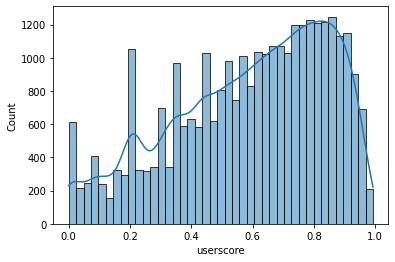

In [10]:
import seaborn as sns
sns.histplot(gamesdb['userscore'], kde=True)

In [11]:
gamesdb.to_csv('test.csv', sep='\t')

In [12]:
np.max(gamesdb['userscore'])

0.9929807556900964

In [13]:
gamesdb = gamesdb.drop_duplicates(subset='appid')

tic = time.time()
tagdb = pd.read_sql_query('SELECT * FROM tags', DB)
lingdb = pd.read_sql_query('SELECT * FROM languages', DB)
genredb = pd.read_sql_query('SELECT * FROM genre', DB)
tagdb = tagdb.drop_duplicates(subset='appid')
lingdb = lingdb.drop_duplicates(subset='appid')
genredb = genredb.drop_duplicates(subset='appid')

In [14]:
genredb.loc[:, genredb.columns != "appid"] = genredb.loc[:, genredb.columns != "appid"].fillna(0)
genredb = genredb.astype(int)

tagdb.loc[:, tagdb.columns != "appid"] = tagdb.loc[:, tagdb.columns != "appid"].fillna(0)
tagdb = tagdb.astype(int)

lingdb.loc[:, lingdb.columns != "appid"] = lingdb.loc[:, lingdb.columns != "appid"].fillna(0)
lingdb = lingdb.astype(int)

In [15]:
lings = list(lingdb.columns)
goodlings = lings[:34]
goodlings.remove('Notsupported')
lingdb = lingdb.loc[:, lingdb.columns.isin(goodlings)]

In [16]:
genretots = genredb.sum()
genretots.pop('id')
genretots.pop('appid')
genretots.sort_values(ascending=False)

Indie                   18465
Action                  11443
Adventure               10187
Casual                   9470
Strategy                 5648
RPG                      5049
Simulation               5042
FreetoPlay               2973
EarlyAccess              2456
Sports                   1146
MassivelyMultiplayer      991
Racing                    961
Utilities                 301
Design&Illustration       198
Animation&Modeling        175
Education                 128
VideoProduction           111
AudioProduction            85
SoftwareTraining           70
GameDevelopment            51
WebPublishing              47
PhotoEditing               46
Violent                    41
Gore                       34
SexualContent              18
Nudity                     15
Accounting                  6
Movie                       1
dtype: int64

In [17]:
lingtots = lingdb.sum()
lingtots.pop('id')
lingtots.pop('appid')
lingtots.sort_values(ascending=False)

English                26653
German                  8151
French                  7777
Russian                 7142
SpanishSpain            7121
SimplifiedChinese       6267
Italian                 5614
Japanese                5301
PortugueseBrazil        3553
Korean                  3286
Polish                  3186
TraditionalChinese      3085
Portuguese              2003
Turkish                 1811
Dutch                   1656
Czech                   1308
Swedish                 1034
Hungarian               1007
Ukrainian                948
SpanishLatinAmerica      935
Danish                   849
Arabic                   798
Norwegian                771
Finnish                  768
Thai                     756
Greek                    673
Romanian                 671
Bulgarian                547
Vietnamese               367
Slovakian                  2
Spanish                    2
dtype: int64

In [18]:
tagtots = tagdb.sum()
tagtots.pop('id')
tagtots.pop('appid')
tagtots.sort_values(ascending=False)

Action          1349979
Indie           1172614
Adventure       1066375
Singleplayer     874724
Multiplayer      795274
                 ...   
Hardware            285
RockMusic           226
Snowboarding        223
Electronic           82
Masterpiece          23
Length: 425, dtype: int64

In [19]:
## Cosine Similarity

In [20]:
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
tagdb = tagdb.set_index('appid')
tagdb = tagdb.drop('id', axis=1)

In [22]:
tagdbnorm = Normalizer(norm='l1').fit_transform(tagdb)

In [23]:
tagsimdb = cosine_similarity(tagdbnorm)

In [24]:
tagsimdb = pd.DataFrame(tagsimdb, index=tagdb.index, columns=tagdb.index)

In [25]:
gamesdb = gamesdb.set_index('appid')

In [26]:
hadesid = gamesdb[gamesdb['name'] == 'Hades'].index[0]
hadesid

1145360

In [27]:
tagdb.shape

(26927, 425)

In [28]:
def get_closest_game(name):
    try:
        gameid = gamesdb[gamesdb['name'] == name].index[0]
    except IndexError:
        raise IndexError('That name {name} is not in the list.')



    return tagsimdb[gameid].sort_values(ascending=False).index[1]

def get_best_nearby_game(name, size=1):
    try:
        gameid = gamesdb[gamesdb['name'] == name].index[0]
    except IndexError:
        raise IndexError('That name {name} is not in the list.')

    target_games = tagsimdb[gameid].index
    comboscores = (gamesdb.loc[target_games]['userscore'] + tagsimdb[gameid]) / 2

    return comboscores.sort_values(ascending=False).index[1:size+1]

In [29]:
# my_top_games = ['XCOM 2', 'Stellaris', 'The Witcher 3: Wild Hunt', 'Darkest Dungeon', 'Fallout 4', 'Enter the Gungeon', 'Outer Wilds']
# closest_games = [get_closest_game(name) for name in my_top_games]
# gamesdb.loc[closest_games]
#

In [30]:
# my_top_games = ['XCOM 2', 'Stellaris', 'The Witcher 3: Wild Hunt', 'Darkest Dungeon', 'Fallout 4', 'Enter the Gungeon', 'Outer Wilds']
# closest_games = [get_best_nearby_game(name) for name in my_top_games]
# gamesdb.loc[closest_games]

In [31]:
gamesdb.loc[get_best_nearby_game('Control Ultimate Edition', size=10)]

,id,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
appid,,,,,,,,,,,,,,,,,
203160,249,Tomb Raider,"Crystal Dynamics, Eidos-Montréal, Feral Intera...","Square Enix, Feral Interactive (Mac), Feral In...",,176637,6816,0.961971,"5,000,000 .. 10,000,000",622,167,508,151,1499,1499,0,1464
108710,230,Alan Wake,Remedy Entertainment,Remedy Entertainment,,30220,2930,0.908510,"2,000,000 .. 5,000,000",346,0,165,0,1499,1499,0,136
391220,672,Rise of the Tomb Raider,"Crystal Dynamics, Eidos-Montréal, Feral Intera...","Square Enix, Feral Interactive (Mac), Feral In...",,87006,5692,0.937033,"2,000,000 .. 5,000,000",1100,89,692,154,999,999,0,1760
752590,899,A Plague Tale: Innocence,Asobo Studio,Focus Home Interactive,,29410,1850,0.938149,"500,000 .. 1,000,000",684,907,756,907,4499,4499,0,218
7000,1030,Tomb Raider: Legend,Crystal Dynamics,Square Enix,,2709,359,0.871130,"500,000 .. 1,000,000",167,0,190,0,699,699,0,53
546560,798,Half-Life: Alyx,Valve,Valve,,52197,716,0.985448,"2,000,000 .. 5,000,000",1069,127,660,126,999,999,0,787
57400,12021,Batman: Arkham City,Rocksteady Studios,Warner Bros. Interactive Entertainment,,1903,21,0.983371,"20,000 .. 50,000",752,0,1018,0,1999,1999,0,0
15130,2048,Beyond Good and Evil,Ubisoft,Ubisoft,,2234,292,0.871345,"200,000 .. 500,000",239,0,329,0,999,999,0,11
601430,1756,The Evil Within 2,Tango Gameworks,Bethesda Softworks,,15749,1299,0.919725,"500,000 .. 1,000,000",587,21,533,21,3999,3999,0,367


In [32]:
kmean = KMeans(n_clusters=14, random_state=0).fit(tagdbnorm)

In [33]:
groups = kmean.predict(tagdbnorm)
groups = pd.Series(groups)


dists = kmean.transform(tagdbnorm)
dists = pd.DataFrame(dists)

In [34]:
groups.groupby(groups).count().sort_values()

11     228
7      448
3      473
12     514
13     663
10     752
0     1484
6     1497
2     1581
4     1894
1     2019
9     2094
5     4042
8     9238
dtype: int64

In [35]:
groups.index = tagdb.index
dists.index = tagdb.index

In [36]:
gamesdb['cluster'] = groups

In [37]:
tagdb.columns[np.argsort(kmean.cluster_centers_[13])[::-1]]

Index(['Adventure', 'Casual', 'Point&Click', 'HiddenObject', 'VR', 'Puzzle',
       'Action', 'VisualNovel', 'Simulation', 'FemaleProtagonist',
       ...
       'TurnBased', 'Tactical', 'ProceduralGeneration', 'BulletHell',
       '4PlayerLocal', 'TopDown', 'TurnBasedStrategy', 'RTS', 'Sandbox',
       'Utilities'],
      dtype='object', length=425)

In [38]:
gamesdb.loc[tagdb.index[np.argsort(dists.values, axis=0)[:, 13][:100]]].sort_values('average_forever', ascending=0).head()

,id,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,cluster
appid,,,,,,,,,,,,,,,,,,
278360,480,A Story About My Uncle,Gone North Games,Coffee Stain Publishing,,24507,2146,0.916156,"5,000,000 .. 10,000,000",809,127,235,127,1499,1499,0,31,13
439190,726,Stories: The Path of Destinies,Spearhead Games,Spearhead Games,,5228,708,0.872236,"2,000,000 .. 5,000,000",411,0,314,0,1499,1499,0,12,13
560740,10512,Shtriga: Summer Camp,Game Cartel,Alawar Entertainment,,62,22,0.635151,"20,000 .. 50,000",355,0,564,0,399,399,0,0,13
415840,4467,Mystic Saga,FIVE-BN GAMES,8Floor,,111,76,0.521989,"100,000 .. 200,000",338,0,346,0,499,499,0,0,13
15700,95,Oddworld: Abe's Oddysee,Oddworld Inhabitants,Oddworld Inhabitants,,3194,524,0.847509,"5,000,000 .. 10,000,000",328,92,223,92,299,299,0,20,13


From my investigating, I'm labeling these clusters:

|Number|Label|
|---|---|
|0|Action Simulation|
|1|Adventure Rpgs with Indie/Anime vibes (JRPGS)?|
|2|Casual Puzzle-Adventures|
|3|Honestly no clue, top responses are "Indie" "Puzzle" "Platformer" "Adventure" "Horror" "Casual"|
|4|Free-To-Play Shovelware|
|5|Violent Shovelware|
|6|Logic/Classical Casual|
|7|Casual|
|8|Strategy Simulation|
|9|Adventure Shovelware|
|10|Tactics|
|11|Software|
|12|Action PvP|
|13|Skill-Based Adventure|

Note: Pretty much all of these categories contain a little action, a little adventure, and a little Indie.
Maybe I should try weighting by review-count?

In [39]:
def upper_bound(s):
    afterdots = s.split(' .. ')[1].replace(',', '')
    return int(afterdots)

In [40]:
gamesdb['owners_upper'] = gamesdb.owners.apply(upper_bound)

In [41]:
# xs = []
# ins = []
# for k in tqdm(range(1, 25)):
#     kmean = KMeans(n_clusters=k, random_state=0).fit(tagdbnorm, sample_weight=gamesdb.owners_upper)
#     avmindist = np.mean(np.min(kmean.transform(tagdbnorm), axis=1))
#     xs.append(avmindist)
#     ins.append(kmean.inertia_)
# plt.plot(xs)

In [42]:
# plt.plot(ins)

In [43]:
kmean = KMeans(n_clusters=7, random_state=0).fit(tagdbnorm, sample_weight=gamesdb.owners_upper)

In [44]:
np.min(kmean.transform(tagdbnorm), axis=1)

array([0.18761127, 0.21842308, 0.28766279, ..., 0.22283463, 0.24054416,
       0.21592853])

In [45]:
groups = kmean.predict(tagdbnorm)
groups = pd.Series(groups)


dists = kmean.transform(tagdbnorm)
dists = pd.DataFrame(dists)

In [46]:
groups.groupby(groups).count().sort_values()

1      937
5     1161
6     1872
3     2714
0     3010
4     4963
2    12270
dtype: int64

In [47]:
groups.index = tagdb.index
dists.index = tagdb.index


gamesdb['cluster'] = groups

In [48]:
tagdb.columns[np.argsort(kmean.cluster_centers_[6])[::-1]]

Index(['FreetoPlay', 'Multiplayer', 'Action', 'MassivelyMultiplayer',
       'Strategy', 'Shooter', 'HeroShooter', 'Coop', 'FPS', 'Indie',
       ...
       'Bikes', 'Collectathon', 'Sequel', 'WordGame', '360Video', 'Gothic',
       'TraditionalRoguelike', 'Trains', 'ImmersiveSim', 'TimeManagement'],
      dtype='object', length=425)

In [49]:
gamesdb.loc[tagdb.index[np.argsort(dists.values, axis=0)[:, 6][:100]]].sort_values('userscore', ascending=False).head()

,id,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,cluster,owners_upper
appid,,,,,,,,,,,,,,,,,,,
312990,562,The Expendabros,Free Lives,Devolver Digital,,16319,475,0.969099,"2,000,000 .. 5,000,000",171,0,76,0,0,0,0,37,6,5000000
714010,886,Aim Lab,Statespace,Statespace,,26467,1329,0.949616,"1,000,000 .. 2,000,000",292,136,53,22,0,0,0,7119,6,2000000
563560,811,Alien Swarm: Reactive Drop,Reactive Drop Team,Reactive Drop Team,,12757,713,0.943157,"2,000,000 .. 5,000,000",176,0,64,0,0,0,0,381,6,5000000
365300,628,Transmissions: Element 120,"Shokunin, Thomas M. Visser, Vincent Thiele",Self Published,,8500,532,0.936053,"500,000 .. 1,000,000",49,40,45,40,0,0,0,7,6,1000000
317360,566,Double Action: Boogaloo,Double Action Factory,Double Action Factory,,9997,798,0.920988,"2,000,000 .. 5,000,000",146,0,77,0,0,0,0,21,6,5000000


|Number|Label|
|---|---|
|0|Multiplayer Action 2D|
|1|FPS Multiplayer|
|2|Indie Adventure|
|3|Tactics/Strategy|
|4|Casual|
|5|Indie/Anime Story-Driven|
|6|Action Free-to-Play|

In [57]:
groups.groupby(groups).count().to_csv('cluster_size.txt', header=False, sep='\t')


In [69]:
import pickle
with open('clusterdict.pkl', 'wb+') as f:
    pickle.dump(gamesdb[['cluster']].to_dict(), f)